# Imprementación de RedesNeuronales con los datos recogidos de Hopu en CTCON
## CON UNA SOLA VARIABLE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler


In [2]:
df = pd.read_csv('calidadAireURDECON.csv',";",index_col=0,squeeze=True)
df = df[["pm25","pm10","co2","humedad","temperatura","presencia"]]# Quito la última columna
#df = df[["pm25","pm10","co2","humedad","temperatura"]]
df = df[["co2"]]# Solo dejo el CO2 porque vamos a jugar con una sola variable
df = df.drop_duplicates(subset=['co2'], keep="last")  # Elimino los duplicados 
#Los registros van de cada 5 minutos. 12 Registros = 1 hora. 48Registros = 4 horas 
df = df[:-48] #Me guardo las últimas 4 horas para la predicción
dfUltimas7Horas = df[-48:]
df.head()

,co2
fecha,
05-10-2021 10:39:17,134.77887
05-10-2021 10:44:17,139.66228
05-10-2021 10:49:17,159.06667
05-10-2021 10:54:17,121.99109
05-10-2021 10:59:18,116.49886


In [3]:
df.describe()
df = df.set_index(pd.to_datetime(df.index, format='%d-%m-%Y %H:%M:%S'))

In [4]:
print(df.index.min())
print(df.index.max())

2021-10-05 10:39:17
2021-10-13 05:23:28


<AxesSubplot:xlabel='fecha'>

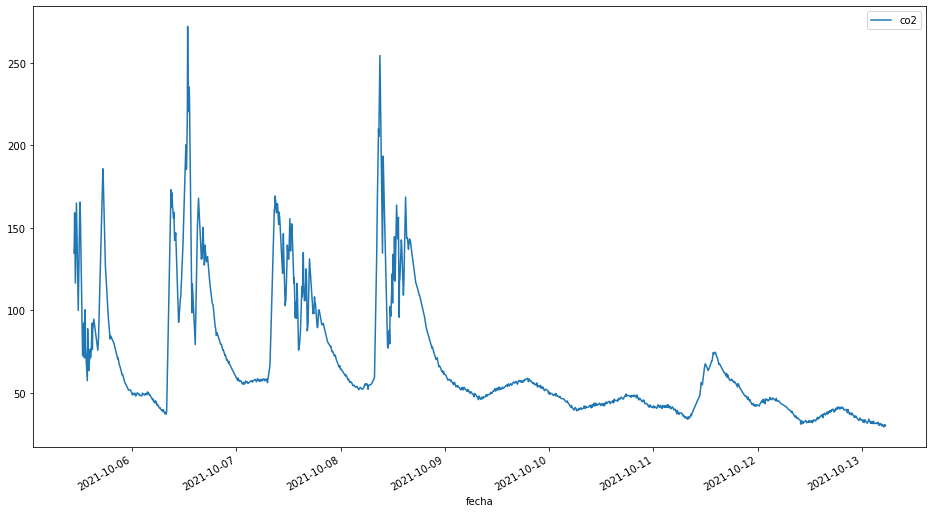

In [5]:
df.plot()

# Comienzo el proceso de reestructuración de datos para la RRNN 

In [6]:
#Si 12 Registros son 1 hora, vamos a entrenar a modelo con intervalos de 1 hora 
PASOS=12 

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] #Si es una lista la dimensión es un, sino, las dimensiones del segundo elemento 
    df = pd.DataFrame(data) # Transformamos a un DataFrame de Panda
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
    
# load dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values) # Transformamos los datos
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
print(reframed.shape)
reframed.head()

(2221, 13)


,var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
12,-0.130897,-0.090662,0.069216,-0.236259,-0.281510,0.024935,-0.060098,0.117786,-0.034289,-0.152582,-0.394639,-0.333377,-0.418213
13,-0.090662,0.069216,-0.236259,-0.281510,0.024935,-0.060098,0.117786,-0.034289,-0.152582,-0.394639,-0.333377,-0.418213,-0.122726
14,0.069216,-0.236259,-0.281510,0.024935,-0.060098,0.117786,-0.034289,-0.152582,-0.394639,-0.333377,-0.418213,-0.122726,-0.145356
15,-0.236259,-0.281510,0.024935,-0.060098,0.117786,-0.034289,-0.152582,-0.394639,-0.333377,-0.418213,-0.122726,-0.145356,0.027105
16,-0.281510,0.024935,-0.060098,0.117786,-0.034289,-0.152582,-0.394639,-0.333377,-0.418213,-0.122726,-0.145356,0.027105,0.076352


In [7]:
# split into train and test sets
values = reframed.values # me quedo solo con los valores del CO2 de la variable Lag
splitParaTrainTest = int( reframed.values.shape[0] * 0.70 ) # Hago el 70% de los datos para separarlos en Traint/Test
train = values[:splitParaTrainTest, :]
test = values[splitParaTrainTest:, :]
print ('train ' + str(train.shape)  + 'test: ' + str(test.shape))

# split into input and outputs. Siempre el Output será el último valor de la variableLag
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
print('x_train - y_test | x_val - y_val', x_train.shape, y_train.shape, x_val.shape, y_val.shape)

# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))

print("/*******************************************************************************/")
print("Datos de ENTRENAMIENTO,  reg en un array tridimensional de "+ str(x_train.shape[0]) +"*(1*1h) -> "+ str(x_train.shape))
print("Datos de VALIDACION del ENTRENAMIENTO, reg en una única dimension ->",y_train.shape)
print("Datos de PREDICCION,  reg en un array tridimensional de "+ str(x_val.shape[0]) +"*(1*1h) -> "+ str(x_val.shape))
print("Datos de VALIDACION de la PREDICCION,  ->", y_val.shape)

train (1554, 13)test: (667, 13)
x_train - y_test | x_val - y_val (1554, 12) (1554,) (667, 12) (667,)
/*******************************************************************************/
Datos de ENTRENAMIENTO,  reg en un array tridimensional de 1554*(1*1h) -> (1554, 1, 12)
Datos de VALIDACION del ENTRENAMIENTO, reg en una única dimension -> (1554,)
Datos de PREDICCION,  reg en un array tridimensional de 667*(1*1h) -> (667, 1, 12)
Datos de VALIDACION de la PREDICCION,  -> (667,)


# Creamos el Modelo de Red Neuronal
## Utilizaremos una Red "normal" Feedforward

In [8]:
'''Entrada 12 inputs, como dijimos antes
1 capa oculta con 7 neuronas (este valor lo escogí yo, pero se puede variar)
La salida será 1 sola neurona
Como función de activación utilizamos tangente hiperbólica puesto que utilizaremos valores entre -1 y 1.
Utilizaremos como optimizador Adam y métrica de pérdida (loss) Mean Absolute Error
Como la predicción será un valor continuo y no discreto, para calcular el Acuracy utilizaremos Mean Squared Error 
y para saber si mejora con el entrenamiento se debería ir reduciendo con las EPOCHS.
'''
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model


In [9]:
EPOCHS=40

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 12)             156       
_________________________________________________________________
flatten (Flatten)            (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
130/130 [==============================] - 0s 2ms/step - loss: 0.0928 - mse: 0.0283 - val_loss: 0.0716 - val_mse: 0.0062
Epoch 2/40
130/130 [==============================] - 0s 607us/step - loss: 0.0681 - mse: 0.0160 - val_loss: 0.0697 - val_mse: 0.0059
Epoch 3/40
130/130 [==============================] - 0s 693us/step - loss: 0.0561 - mse: 0.0102 - val_loss: 0.0618 - val_

## Validamos Resultados

(667, 1, 12)
300


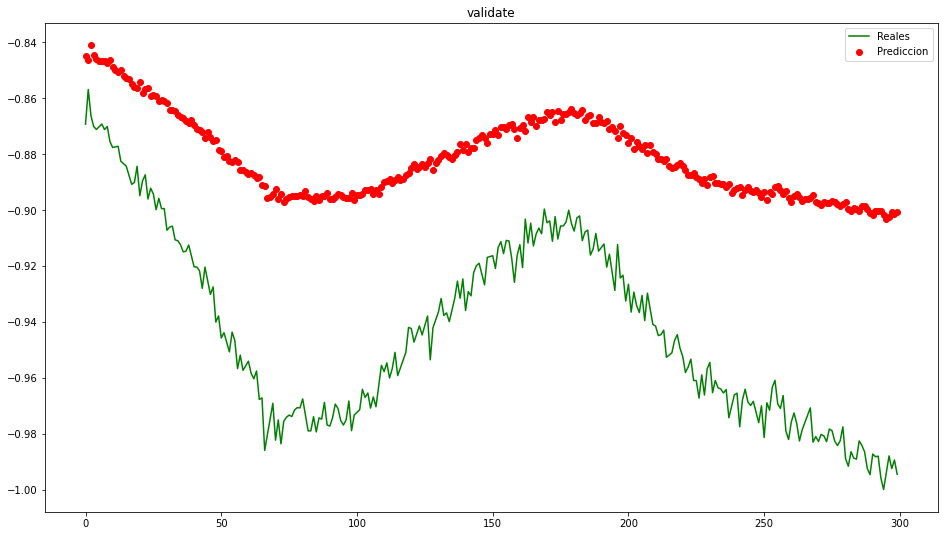

In [10]:
print(x_val.shape)
results=model.predict(x_val[-300:])#Predicción de los últimos 300 datos de validación
print( len(results) )
plt.plot(range(len(y_val[-300:])),y_val[-300:],c='g') #Pinto los datos reales de la validación
plt.scatter(range(len(results)),results,c='r') #Pinto los datos predichos de por la RRNN
plt.title('validate')

plt.legend( ["Reales","Prediccion"])
plt.show()


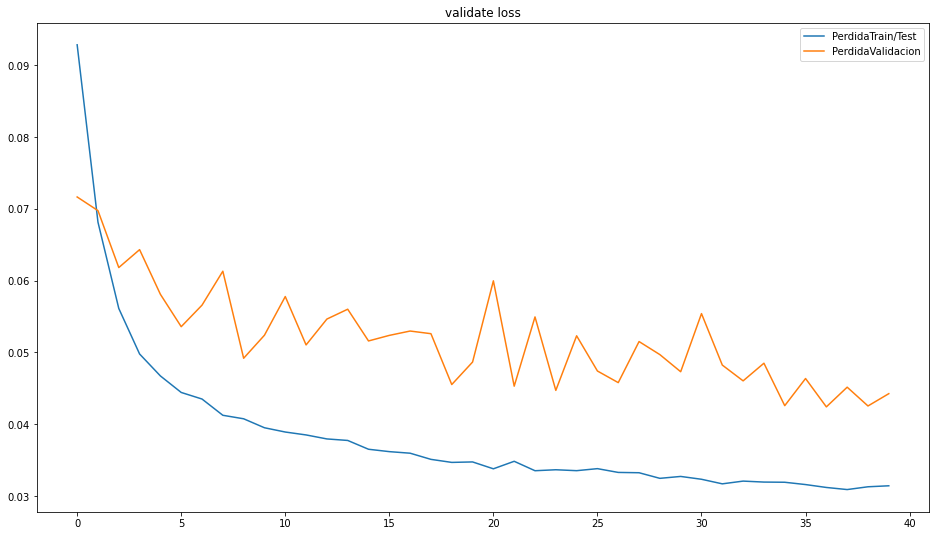

In [11]:
#Pérdida de la RRNN
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.legend( ["PerdidaTrain/Test","PerdidaValidacion"])
plt.show()

## Validación del pronostico, 

In [24]:
dfUltimas7Horas.head()

,co2
fecha,
13-10-2021 01:22:33,32.740295
13-10-2021 01:27:47,33.744022
13-10-2021 01:33:01,34.034040
13-10-2021 01:37:35,33.011620
13-10-2021 01:42:49,32.817238


In [25]:
#Preparamos los datos 
values = dfUltimas7Horas.values
values = values.astype('float32')

# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head()


,var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
12,0.453963,0.877596,1.000000,0.568479,0.486438,0.722335,0.073479,0.238827,0.402544,0.211010,-0.110021,0.094543
13,0.877596,1.000000,0.568479,0.486438,0.722335,0.073479,-0.083625,0.402544,0.211010,-0.110021,0.094543,0.221509
14,1.000000,0.568479,0.486438,0.722335,0.073479,-0.083625,0.238827,0.211010,-0.110021,0.094543,0.221509,0.300515
15,0.568479,0.486438,0.722335,0.073479,-0.083625,0.238827,0.402544,-0.110021,0.094543,0.221509,0.300515,0.495987
16,0.486438,0.722335,0.073479,-0.083625,0.238827,0.402544,0.211010,0.094543,0.221509,0.300515,0.495987,-0.131181


In [26]:
values = reframed.values
print(values)
x_test = values[:, :]
print(x_test)
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)


[[ 0.45396328  0.8775959   1.          0.5684786   0.4864378   0.72233486
   0.0734787   0.23882675  0.40254402  0.21100998 -0.11002064  0.0945425 ]
 [ 0.8775959   1.          0.5684786   0.4864378   0.72233486  0.0734787
  -0.08362484  0.40254402  0.21100998 -0.11002064  0.0945425   0.22150898]
 [ 1.          0.5684786   0.4864378   0.72233486  0.0734787  -0.08362484
   0.23882675  0.21100998 -0.11002064  0.0945425   0.22150898  0.30051517]
 [ 0.5684786   0.4864378   0.72233486  0.0734787  -0.08362484  0.23882675
   0.40254402 -0.11002064  0.0945425   0.22150898  0.30051517  0.49598694]
 [ 0.4864378   0.72233486  0.0734787  -0.08362484  0.23882675  0.40254402
   0.21100998  0.0945425   0.22150898  0.30051517  0.49598694 -0.13118076]
 [ 0.72233486  0.0734787  -0.08362484  0.23882675  0.40254402  0.21100998
  -0.11002064  0.22150898  0.30051517  0.49598694 -0.13118076 -0.03035069]
 [ 0.0734787  -0.08362484  0.23882675  0.40254402  0.21100998 -0.11002064
   0.0945425   0.30051517  0.4959

In [27]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

In [28]:
results=[]
#print(x_test.shape)
for i in range(72):
    parcial=model.predict(x_test)
    #print(parcial)
    results.append(parcial[0])
    #print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])
print(len(results))

7


In [29]:
adimen = [x for x in results]    
#print(adimen)
inverted = scaler.inverse_transform(adimen)
#inverted

<AxesSubplot:>

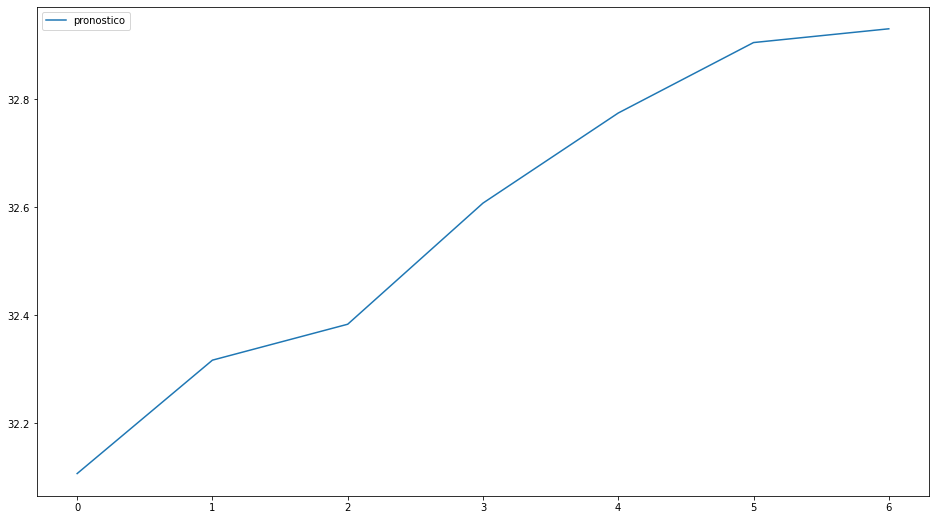

In [30]:
prediccionSiguientes24Reg = pd.DataFrame(inverted)
prediccionSiguientes24Reg.columns = ['pronostico']
prediccionSiguientes24Reg.plot()

(7, 1)
7


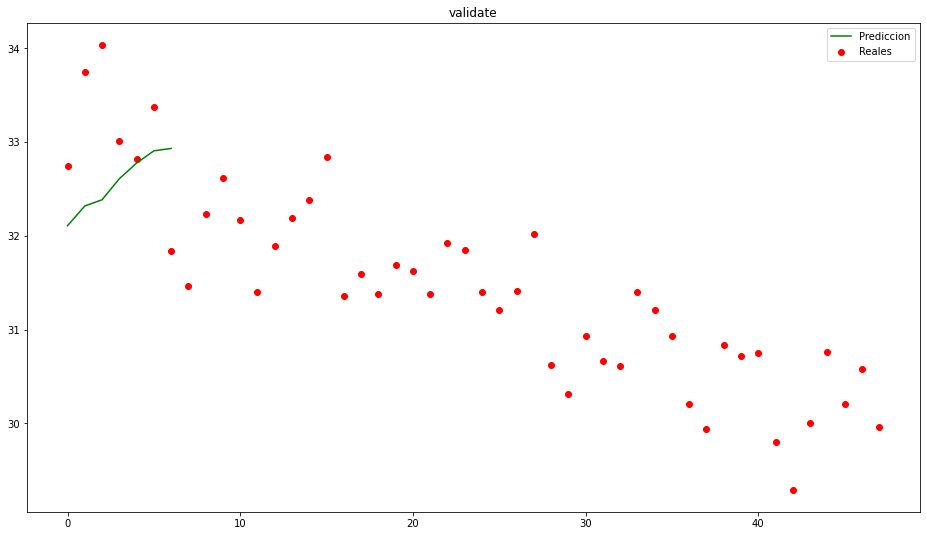

In [31]:
print(prediccionSiguientes24Reg.shape)
print( len(prediccionSiguientes24Reg) )
plt.plot(range(len(prediccionSiguientes24Reg)),prediccionSiguientes24Reg,c='g')
plt.scatter(range(len(dfUltimas7Horas)),dfUltimas7Horas,c='r')
plt.title('validate')

plt.legend( ["Prediccion","Reales"])
plt.show()